# Elasticity workflow using MatMethods

In this excercise we will use the [MatMethods](https://github.com/hackingmaterials/MatMethods.git) package and VASP to compute the elastic properties of Silicon.

Set environment variables and setup simulated vasp run

In [1]:
%matplotlib inline

import os
from helper_functions import *

db_file = os.path.abspath("db.json")
#db_file=">>db_file<<"

# Structure

In [2]:
from pymatgen import Structure

struct_si = Structure([[5.468344455957462, 0.0, -0.0], 
                       [-0.0, 5.468344455957462, 0.0], 
                       [0.0, -0.0, 5.468344455957462]], 
                      
                      ["Si"]*8, 
                      
                      [[-0.0, -0.0, 0.5],
                       [0.75, 0.75, 0.75],
                       [0.0, 0.5, -0.0],
                       [0.75, 0.25, 0.25],
                       [0.5, 0.0, -0.0],
                       [0.25, 0.75, 0.25],
                       [0.5, 0.5, 0.5],
                       [0.25, 0.25, 0.75]])

# vasp inputset: MPRelaxSet

In [3]:
from pymatgen.io.vasp.sets import MPRelaxSet, DictSet

vis = MPRelaxSet(struct_si, force_gamma=True)
vis.config_dict["KPOINTS"].update({"reciprocal_density": 600})
vis = DictSet(struct_si, vis.config_dict)

# Structure optimization firework

In [4]:
from fireworks import Workflow
from matmethods.vasp.fireworks.core import OptimizeFW


vasp_cmd=None

fws = []
fw1 = OptimizeFW(struct_si, vasp_input_set=vis, vasp_cmd=vasp_cmd, db_file=db_file)
fws.append(fw1)

# Deformation fireworks

define normal and shear deformations

In [5]:
from pymatgen.analysis.elasticity.strain import Deformation

norm_deformations=[-0.01, -0.005, 0.005, 0.01]
shear_deformations=[-0.06, -0.03, 0.03, 0.06]

deformations = []
#Normal deformations
for ind in [(0, 0), (1, 1), (2, 2)]:
    for amount in norm_deformations:
        defo = Deformation.from_index_amount(ind, amount)
        deformations.append(defo)
        
#Shear deformations
for ind in [(0, 1), (0, 2), (1, 2)]:
    for amount in shear_deformations:
        defo = Deformation.from_index_amount(ind, amount)
        deformations.append(defo)

Update incar and kpoint settings

In [6]:
#update incar file settings
def_incar_settings = vis.incar.as_dict()
def_incar_settings.update({"ISIF":2, "ISTART":1})
for key in ["MAGMOM", "@module", "@class", "LDAUU", "LDAUJ", "LDAUL"]:
    def_incar_settings.pop(key, None)

def_vasp_params = {"user_incar_settings":def_incar_settings}
def_vasp_params.update({"reciprocal_density": 600})

Define firework for each deformation. A total of 24 deformation fireworks

In [7]:
from fireworks import Firework
from matmethods.vasp.fireworks.core import TransmuterFW
from matmethods.vasp.workflows.base.elastic import PassStressStrainData

#generate deformation fireworks; one for each deformation
for i, deformation in enumerate(deformations):
    fw = TransmuterFW(name="elastic_deformation_"+str(i+1),
                      structure=struct_si,
                      transformations=['DeformStructureTransformation'],
                      transformation_params=[{"deformation": deformation.tolist()}],
                      copy_vasp_outputs=True,
                      db_file=db_file,
                      vasp_cmd=vasp_cmd,
                      parents=fws[0],
                      vasp_input_params=def_vasp_params
                     )
    fw.spec['_tasks'].append(PassStressStrainData(deformation=deformation.tolist()).to_dict())
    fws.append(fw)

# Stress-strain analyzer firework

In [8]:
from matmethods.vasp.workflows.base.elastic import AnalyzeStressStrainData

fws.append(Firework(AnalyzeStressStrainData(structure=struct_si, db_file=db_file),
                    name="Analyze Elastic Data", parents=fws[1:],
                    spec={"_allow_fizzled_parents": True}))

wfname = "{}:{}".format(struct_si.composition.reduced_formula, "elastic constants")

wf = Workflow(fws, name=wfname)

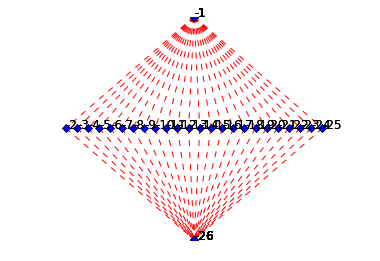

In [9]:
plot_wf(wf, depth_factor=10.0, numerical_label=True)

# Powerups

use the powerup to modify incar paramters: ENCUT and EDIFF

In [10]:
from matmethods.vasp.vasp_powerups import add_modify_incar
from matmethods.vasp.workflows.presets.core import add_common_powerups

wf = add_modify_incar(wf, modify_incar_params={"incar_update": {"ENCUT": 700, "EDIFF": 1e-6}})
c = {"VASP_CMD": vasp_cmd, "DB_FILE": db_file, "reciprocal_density": 600}
wf = add_common_powerups(wf, c)

# Simulate vasp run

In [11]:
wf = simulate_elasticity_vasprun(wf, deformations, ref_dir=os.path.abspath("."))

# Connect to Launchpad and reset

In [12]:
from fireworks import LaunchPad

lp = LaunchPad()
lp.reset("", require_password=False)

2016-08-09 11:50:29,580 INFO Performing db tune-up
2016-08-09 11:50:29,589 INFO LaunchPad was RESET.


# Submit Workflow

In [13]:
lp.add_wf(wf)

2016-08-09 11:50:31,661 INFO Added a workflow. id_map: {-1: 26, -26: 1, -25: 2, -24: 3, -23: 4, -22: 5, -21: 6, -20: 7, -19: 8, -18: 9, -17: 10, -16: 11, -15: 12, -14: 13, -13: 14, -12: 15, -11: 16, -10: 17, -9: 18, -8: 19, -7: 20, -6: 21, -5: 22, -4: 23, -3: 24, -2: 25}


{-26: 1,
 -25: 2,
 -24: 3,
 -23: 4,
 -22: 5,
 -21: 6,
 -20: 7,
 -19: 8,
 -18: 9,
 -17: 10,
 -16: 11,
 -15: 12,
 -14: 13,
 -13: 14,
 -12: 15,
 -11: 16,
 -10: 17,
 -9: 18,
 -8: 19,
 -7: 20,
 -6: 21,
 -5: 22,
 -4: 23,
 -3: 24,
 -2: 25,
 -1: 26}